# Xarray interface for neoclassical transport

## `SymbolicEquilibrium`

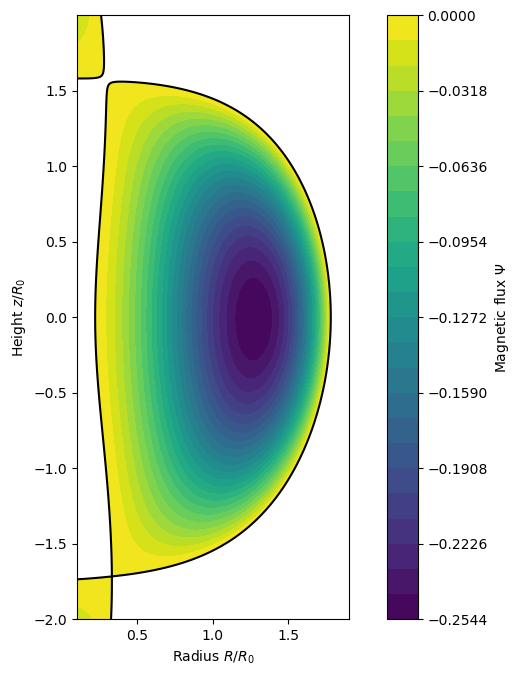

In [1]:
from plasmaboundaries import NSTX_single_null

NSTX_single_null

NSTX_Bt0 = 0.3 * u.T
NSTX_R0 = 0.8 * u.m
NSTX_a0 = 0.64 * u.m
NSTX_I = 1 * u.MA
from plasmapy.plasma.symbolicequilibrium import SymbolicEquilibrium

params = {"aspect_ratio": 1.25, "A": -0.05, "elongation": 2, "triangularity": 0.3}
# TODO this is still not taken in

eq = SymbolicEquilibrium(
    **NSTX_single_null,
    B0=NSTX_Bt0.si.value,  # TODO handle quantity input
    config="single-null",
)
rminmaxstep = (
    0.1,
    1.9,
    0.001,
)  # these definitely, unfortunately, need to be moved into SymbolicEquilibrium
zminmaxstep = (-2, 2, 0.001)
eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep);

In [2]:
import astropy.units as u
import numpy as np
import pandas as pd
import xarray

data_df = pd.read_csv("/home/dominik/HoulbergNSTX.csv", index_col=0)

<AxesSubplot:xlabel='x'>

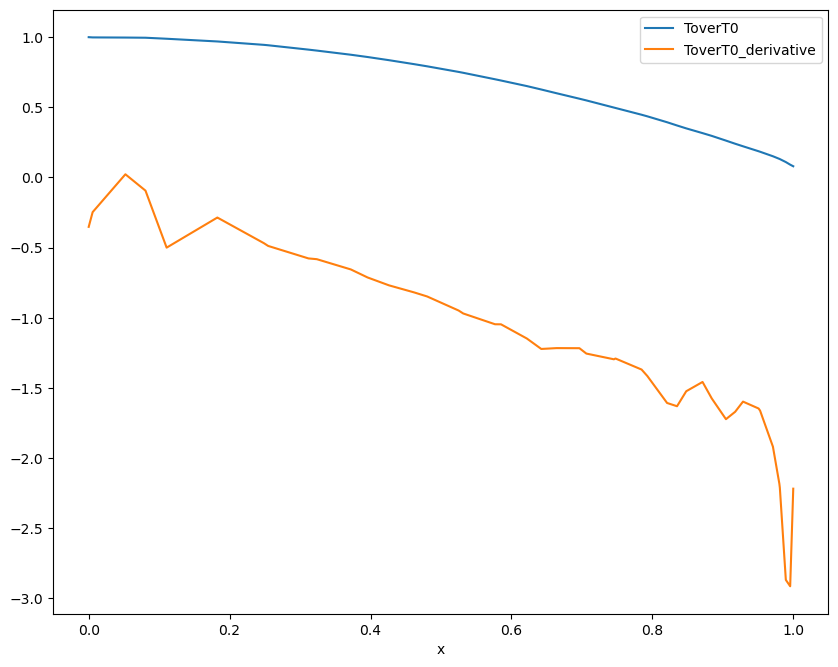

In [45]:
data_df[["x", "ToverT0", "ToverT0_derivative"]].plot(x="x")

<AxesSubplot:xlabel='x'>

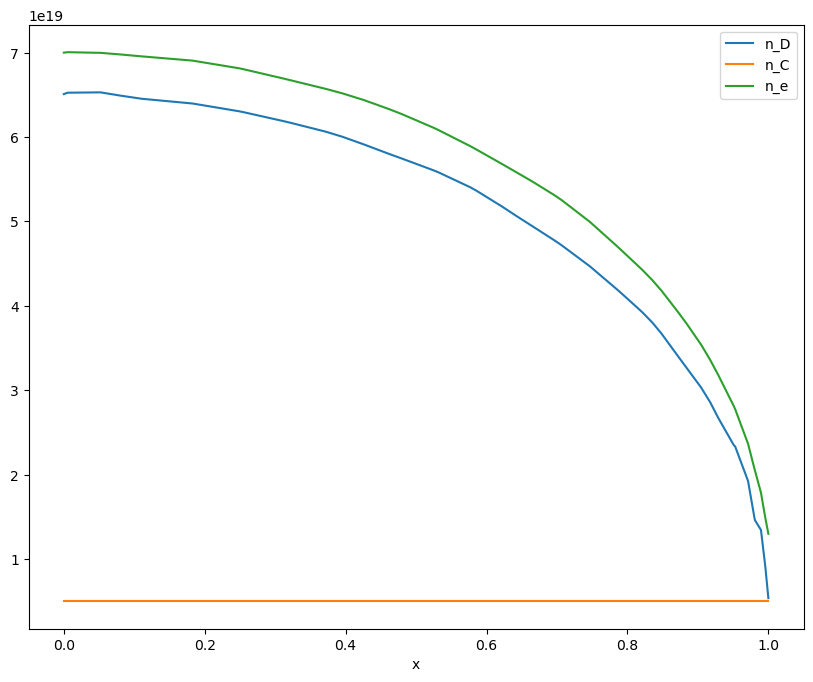

In [46]:
data_df[["x", "n_D", "n_C", "n_e"]].plot(x="x")

<AxesSubplot:xlabel='x'>

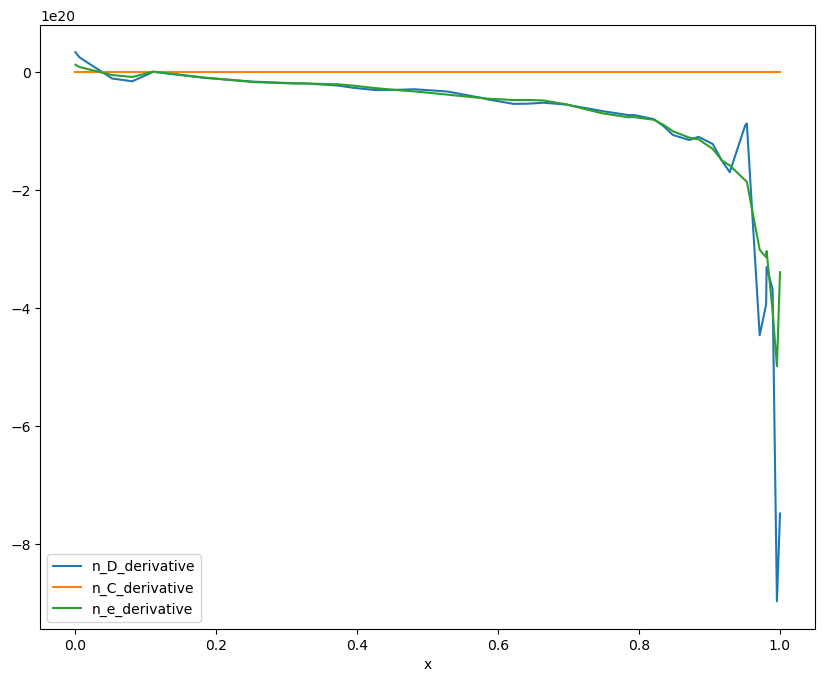

In [47]:
data_df[["x", "n_D_derivative", "n_C_derivative", "n_e_derivative"]].plot(x="x")

In [40]:
T_i = T_e = T_C6 = data_df["ToverT0"] * 0.5 * 1000
dT_i = dT_e = dT_C6 = data_df["ToverT0_derivative"] * 0.5 * 1000
n_e, dn_e = data_df["n_e"], data_df["n_e_derivative"]
n_i, dn_i = data_df["n_D"], data_df["n_D_derivative"]
n_C6, dn_C6 = data_df["n_C"], data_df["n_C_derivative"]

rho = data_df.x.values

array([0.     , 0.0056 , 0.05209, 0.0806 , 0.11061, 0.11063, 0.18263,
       0.1827 , 0.24879, 0.25468, 0.31192, 0.32376, 0.37206, 0.39584,
       0.42621, 0.46194, 0.48038, 0.52506, 0.53156, 0.57674, 0.5852 ,
       0.62193, 0.64235, 0.66413, 0.6965 , 0.70633, 0.74553, 0.74768,
       0.78473, 0.79287, 0.82094, 0.83506, 0.84812, 0.87127, 0.88433,
       0.90449, 0.91755, 0.9287 , 0.95076, 0.95293, 0.97116, 0.98032,
       0.98098, 0.98948, 0.99565, 1.     ])

## Multiple flux surfaces - radial grid

In [13]:
from tqdm.auto import tqdm

In [14]:
surfaces = list(
    tqdm(
        eq.get_multiple_flux_surfaces(
            rho_values=rho, rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep
        ),
        total=len(rho),
    )
)

ax = eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
for psi, fs in surfaces:
    if fs is not None:
        fs.plot(ax)
ax.legend().remove()
plt.tight_layout()

## `FlowCalculator`

In [17]:
rho_to_surface = {key: value for key, value in surfaces};

In [18]:
import xarray

dataset_H1 = xarray.Dataset(
    {
        "T": ("rho", T_i),
        "gradT": ("rho", dT_i),
        "n": ("rho", n_i),
        "gradn": ("rho", dn_i),
    },
    coords={"rho": rho, "particle": "H 1+"},
    attrs={
        "T unit": u.eV,
        "n unit": u.m ** -3,
        "gradT unit": u.eV / u.m,
        "gradn unit": u.m ** -3 / u.m,
    },
)

dataset_C6 = xarray.Dataset(
    {
        "T": ("rho", T_C6),
        "gradT": ("rho", dT_C6),
        "n": ("rho", n_C6),
        "gradn": ("rho", dn_C6),
    },
    coords={"rho": rho, "particle": "C 6+"},
    attrs={
        "T unit": u.eV,
        "n unit": u.m ** -3,
        "gradT unit": u.eV / u.m,
        "gradn unit": u.m ** -3 / u.m,
    },
)
dataset_e = xarray.Dataset(
    {
        "T": ("rho", T_e),
        "gradT": ("rho", dT_e),
        "n": ("rho", n_e),
        "gradn": ("rho", dn_e),
    },
    coords={"rho": rho, "particle": "e-"},
    attrs={
        "T unit": u.eV,
        "n unit": u.m ** -3,
        "gradT unit": u.eV / u.m,
        "gradn unit": u.m ** -3 / u.m,
    },
)

dataset = xarray.concat([dataset_H1, dataset_C6, dataset_e], dim="particle")
# dataset["rho"] = ("rho", rho)
dataset["charges"] = ("particle", [1, 6, -1])
dataset["charge_density"] = "rho", (dataset.charges * dataset.n).sum(dim="particle")
dataset

<xarray.Dataset>
Dimensions:         (particle: 3, rho: 46)
Coordinates:
  * rho             (rho) float64 0.0 0.0056 0.05209 ... 0.9895 0.9957 1.0
  * particle        (particle) <U4 'H 1+' 'C 6+' 'e-'
Data variables:
    T               (particle, rho) float64 500.0 499.2 498.6 ... 45.67 39.98
    gradT           (particle, rho) float64 -176.0 -123.5 ... -1.109e+03
    n               (particle, rho) float64 6.509e+19 6.525e+19 ... 1.299e+19
    gradn           (particle, rho) float64 3.285e+19 2.42e+19 ... -3.396e+20
    charges         (particle) int64 1 6 -1
    charge_density  (rho) float64 2.509e+19 2.52e+19 ... 2.422e+19 2.238e+19
Attributes:
    T unit:      eV
    n unit:      1 / m3
    gradT unit:  eV / m
    gradn unit:  1 / m4

In [19]:
dataset["psi"] = eq.rho_to_psi(rho)
dataset

<xarray.Dataset>
Dimensions:         (particle: 3, psi: 46, rho: 46)
Coordinates:
  * rho             (rho) float64 0.0 0.0056 0.05209 ... 0.9895 0.9957 1.0
  * particle        (particle) <U4 'H 1+' 'C 6+' 'e-'
  * psi             (psi) float64 -0.2544 -0.2529 -0.2411 ... -0.001106 0.0
Data variables:
    T               (particle, rho) float64 500.0 499.2 498.6 ... 45.67 39.98
    gradT           (particle, rho) float64 -176.0 -123.5 ... -1.109e+03
    n               (particle, rho) float64 6.509e+19 6.525e+19 ... 1.299e+19
    gradn           (particle, rho) float64 3.285e+19 2.42e+19 ... -3.396e+20
    charges         (particle) int64 1 6 -1
    charge_density  (rho) float64 2.509e+19 2.52e+19 ... 2.422e+19 2.238e+19
Attributes:
    T unit:      eV
    n unit:      1 / m3
    gradT unit:  eV / m
    gradn unit:  1 / m4

In [20]:
from tqdm import auto as tqdm

from plasmapy.transport.flows import FlowCalculator

fcs = []
import warnings

for i, (ψ, surface) in enumerate(tqdm.tqdm(surfaces)):
    if surface is None:
        print(f"Skipping {i}-th surface at {ψ}")
        continue
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fcs.append(FlowCalculator.from_xarray_surface(dataset.isel(rho=i), surface))
    except ImportError as e:
        display(e)

  0%|          | 0/46 [00:00<?, ?it/s]

e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.


In [21]:
datasets = [fc.to_dataset() for fc in tqdm.tqdm(fcs)];

  0%|          | 0/46 [00:00<?, ?it/s]

/usr/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[<xarray.Dataset>
 Dimensions:                (particle: 3, psi: 46)
 Coordinates:
   * particle               (particle) <U4 'C 6+' 'H 1+' 'e-'
   * psi                    (psi) float64 -0.2544 -0.2529 ... -0.001106 0.0
     rho                    float64 0.0
 Data variables: (12/17)
     total_particle_flux    (particle) float64 -4.169e+17 -2.95e+19 nan
     total_heat_flux        (particle) float64 -48.77 -3.141e+03 nan
     BP_particle_flux       (particle) float64 -4.195e+17 -2.948e+19 nan
     BP_heat_flux           (particle) float64 -47.94 -3.138e+03 nan
     CL_particle_flux       (particle) float64 1.875e+15 -1.223e+16 nan
     CL_heat_flux           (particle) float64 -0.592 -1.907 nan
     ...                     ...
     T                      (particle) float64 500.0 500.0 500.0
     gradT                  (particle) float64 -176.0 -176.0 -176.0
     n                      (particle) float64 5e+18 6.509e+19 7e+19
     gradn                  (particle) float64 -5.897e+04 3

In [22]:
results = xarray.concat(datasets, dim="rho")
scaling = (fcs[0].bootstrap_current.unit / NSTX_Bt0).to(u.MA / u.m ** 2)
results = results.assign(
    bootstrap_current_normalized=results.bootstrap_current * scaling
)

<xarray.Dataset>
Dimensions:                       (particle: 3, psi: 46, rho: 46)
Coordinates:
  * particle                      (particle) <U4 'C 6+' 'H 1+' 'e-'
  * psi                           (psi) float64 -0.2544 -0.2529 ... 0.0
  * rho                           (rho) float64 0.0 0.0056 ... 0.9957 1.0
Data variables: (12/18)
    total_particle_flux           (rho, particle) float64 -4.169e+17 ... nan
    total_heat_flux               (rho, particle) float64 -48.77 ... nan
    BP_particle_flux              (rho, particle) float64 -4.195e+17 ... nan
    BP_heat_flux                  (rho, particle) float64 -47.94 ... nan
    CL_particle_flux              (rho, particle) float64 1.875e+15 ... nan
    CL_heat_flux                  (rho, particle) float64 -0.592 -1.907 ... nan
    ...                            ...
    gradT                         (rho, particle) float64 -176.0 ... -1.109e+03
    n                             (rho, particle) float64 5e+18 ... 1.299e+19
    gradn                         (rho, particle) float64 -5.897e+04 ... -3.3...
    charges                       (rho, particle) int64 6 1 -1 6 1 ... -1 6 1 -1
    charge_density                (rho) float64 2.509e+19 2.52e+19 ... 2.238e+19
    bootstrap_current_normalized  (rho) float64 -0.004105 -0.01201 ... 0.0596

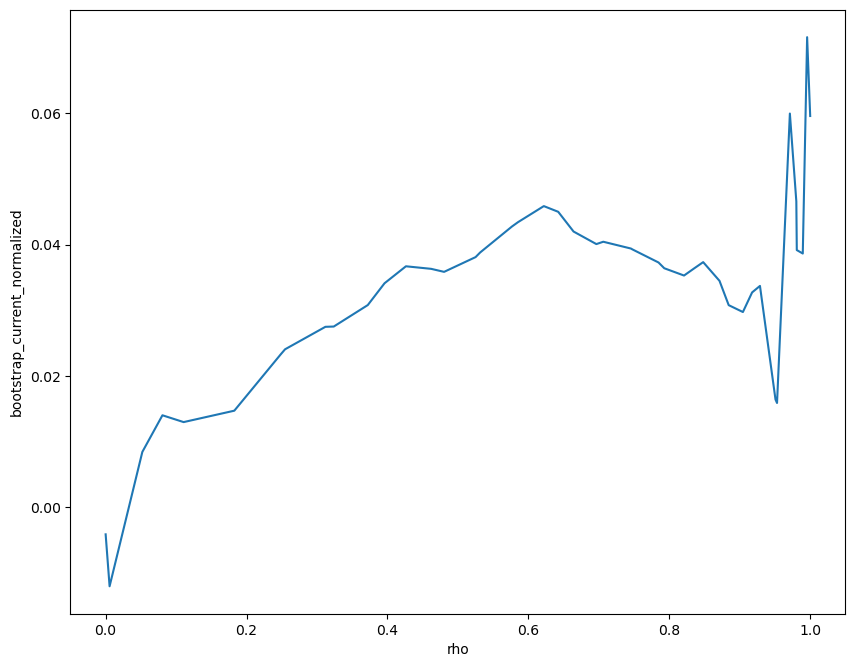

In [23]:
results.bootstrap_current_normalized.plot.line()

In [24]:
results.thermal_conductivity

<xarray.DataArray 'thermal_conductivity' (rho: 46, particle: 3)>
array([[-2.38776760e-05, -1.53782265e-03,             nan],
       [-7.95727564e-03, -3.81239500e-02,             nan],
       [-1.88917355e-01, -1.27885863e-01,             nan],
       [ 1.67220901e-02, -1.36769364e-02,             nan],
       [-3.06199744e-02, -2.86851576e-02,             nan],
       [-3.06231722e-02, -2.86838539e-02,             nan],
       [-1.93432928e-02, -2.39387039e-02,             nan],
       [-1.93485366e-02, -2.39388017e-02,             nan],
       [-1.78410231e-02, -2.23204096e-02,             nan],
       [-1.77844697e-02, -2.21989481e-02,             nan],
       [-1.65091319e-02, -2.10448996e-02,             nan],
       [-1.62624065e-02, -2.08260932e-02,             nan],
       [-1.50223982e-02, -1.99775485e-02,             nan],
       [-1.42295190e-02, -1.95753598e-02,             nan],
       [-1.35060683e-02, -1.90756658e-02,             nan],
       [-1.33124864e-02, -1.85204054e-02,             nan],
       [-1.32715977e-02, -1.82579104e-02,             nan],
       [-1.26634888e-02, -1.76750071e-02,             nan],
       [-1.25468068e-02, -1.75930427e-02,             nan],
       [-1.14437776e-02, -1.70245800e-02,             nan],
...
       [-9.27128620e-03, -1.47275132e-02,             nan],
       [-9.21355164e-03, -1.46963625e-02,             nan],
       [-8.63181986e-03, -1.40845022e-02,             nan],
       [-8.58339530e-03, -1.39446850e-02,             nan],
       [-8.18035495e-03, -1.34707211e-02,             nan],
       [-7.69087426e-03, -1.32118085e-02,             nan],
       [-7.01700073e-03, -1.29091517e-02,             nan],
       [-6.23364136e-03, -1.21523789e-02,             nan],
       [-6.07600020e-03, -1.16523229e-02,             nan],
       [-5.48398551e-03, -1.09131575e-02,             nan],
       [-4.84340995e-03, -1.03917971e-02,             nan],
       [-4.33976194e-03, -9.81883417e-03,             nan],
       [-4.07599058e-03, -8.21966406e-03,             nan],
       [-4.03560079e-03, -8.12237961e-03,             nan],
       [-2.91165930e-03, -7.78414306e-03,             nan],
       [-2.85201168e-03, -5.89645157e-03,             nan],
       [-2.89633742e-03, -5.58227343e-03,             nan],
       [-2.90455062e-03, -4.94196749e-03,             nan],
       [-2.59727015e-03, -4.54843482e-03,             nan],
       [-1.48930087e-03, -2.23683689e-03,             nan]])
Coordinates:
  * particle  (particle) <U4 'C 6+' 'H 1+' 'e-'
  * rho       (rho) float64 0.0 0.0056 0.05209 0.0806 ... 0.9895 0.9957 1.0

In [25]:
results.diffusion_coefficient.sel(particle="C 6+")

<xarray.DataArray 'diffusion_coefficient' (rho: 46)>
array([-7.06831865e+12, -5.23313674e+14, -2.84944433e+14,  4.13151142e+13,
        8.87955072e+13,  8.87299931e+13, -1.82048384e+13, -1.82439132e+13,
        5.67134412e+14, -1.14414674e+15,  8.68239037e+16, -8.04166836e+15,
        9.12523102e+15, -1.87896287e+16, -2.17260977e+16, -1.44490519e+17,
       -3.24441088e+16, -1.48270110e+16, -1.56676363e+16,  4.30687403e+16,
       -7.79051467e+16,  9.04922922e+16, -4.21765013e+16, -8.05104877e+16,
        3.87073321e+16, -1.86840253e+16,  5.41076469e+15,  5.33692395e+15,
        2.98552206e+16,  2.81463175e+16, -3.21403000e+17,  4.60154911e+16,
        9.54490094e+15, -9.87295830e+15, -6.06393671e+15,  1.58124747e+16,
       -2.30770183e+16, -1.29770649e+16, -1.28131349e+16,  4.42734354e+17,
       -8.63251887e+14,  2.72168469e+14,  2.86912586e+14, -1.01534574e+15,
        2.49912263e+15,             inf])
Coordinates:
    particle  <U4 'C 6+'
  * rho       (rho) float64 0.0 0.0056 0.05209 0.0806 ... 0.9895 0.9957 1.0

(-10.0, 10.0)

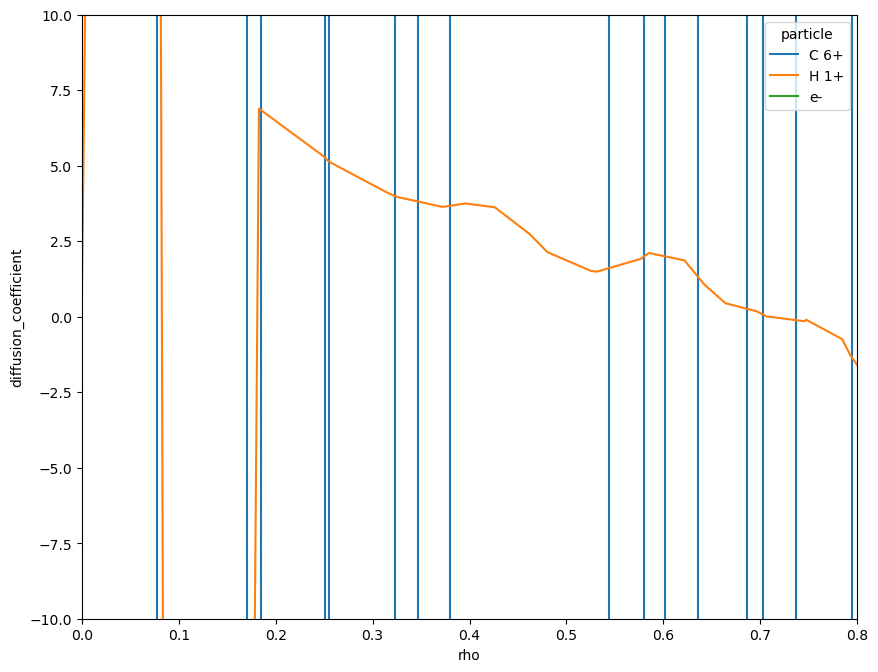

In [26]:
results.diffusion_coefficient.plot.line(x="rho")
plt.xlim(0, 0.8)
plt.ylim(-10, 10)

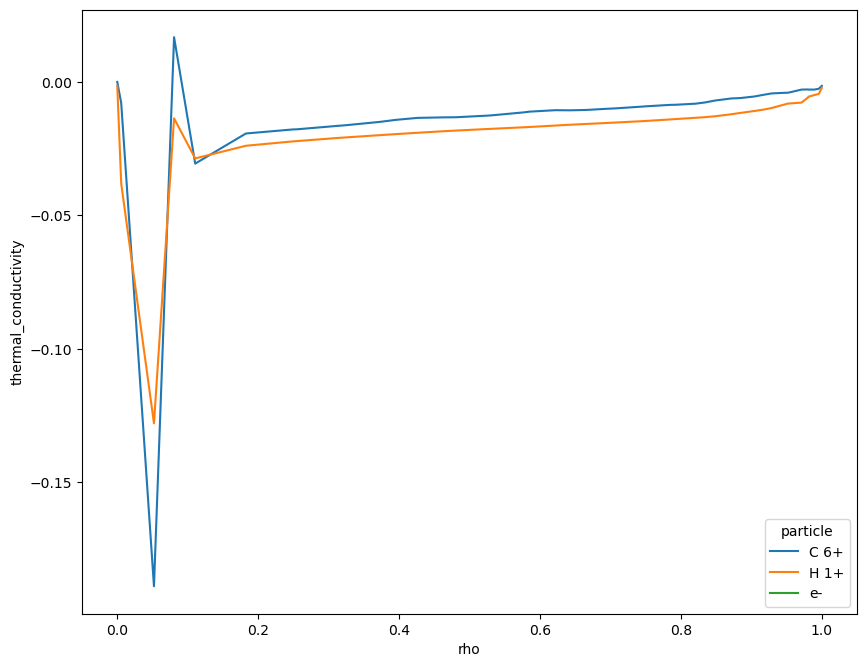

In [27]:
results.thermal_conductivity.plot.line(x="rho")

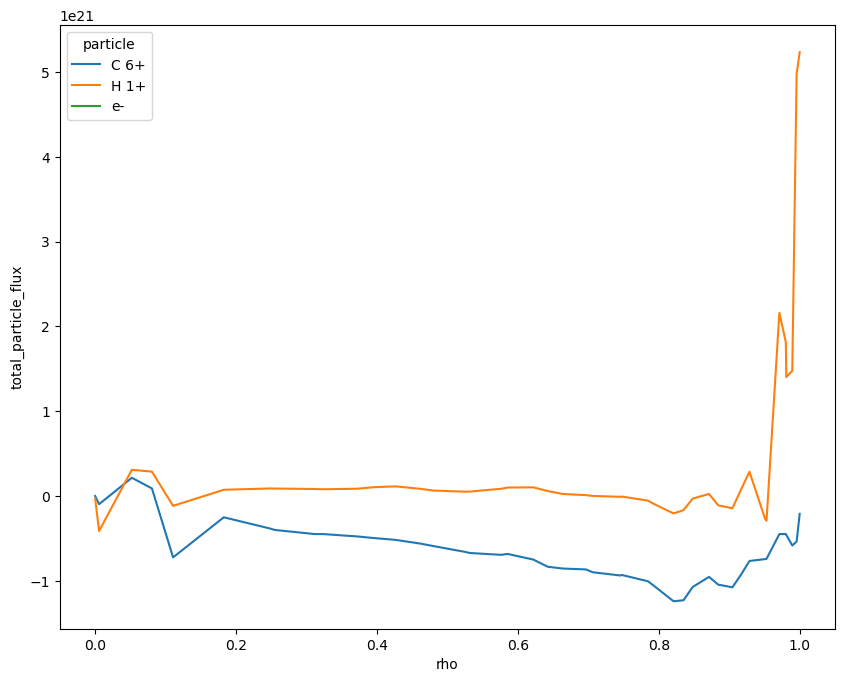

In [28]:
results.total_particle_flux.plot.line(x="rho")

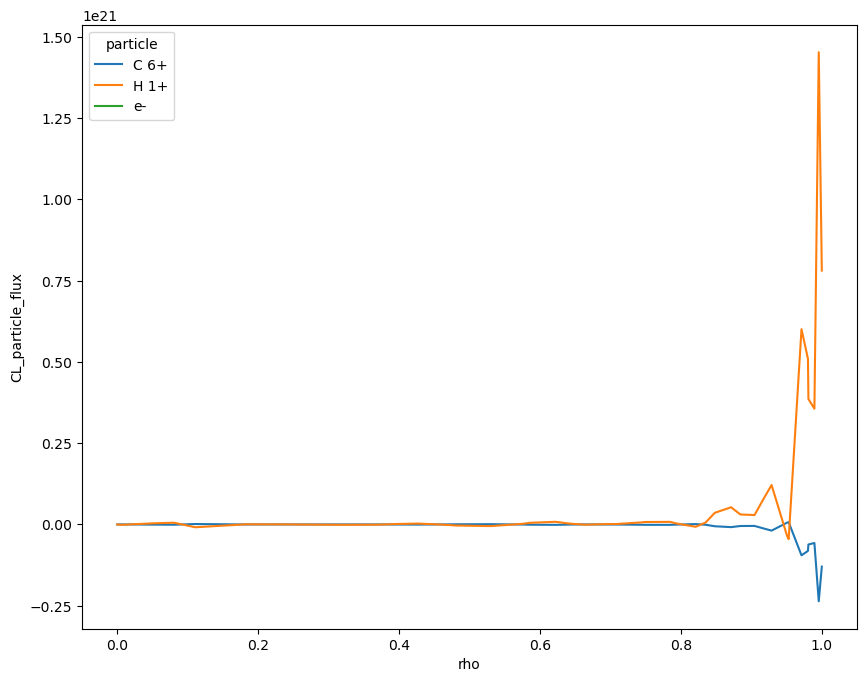

In [29]:
results.CL_particle_flux.plot.line(x="rho")

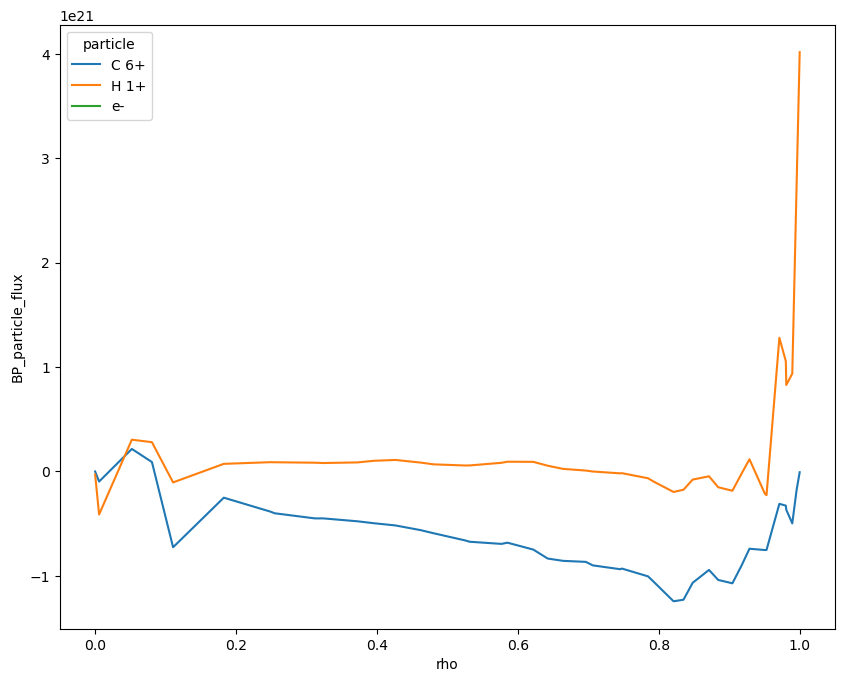

In [30]:
results.BP_particle_flux.plot.line(x="rho")

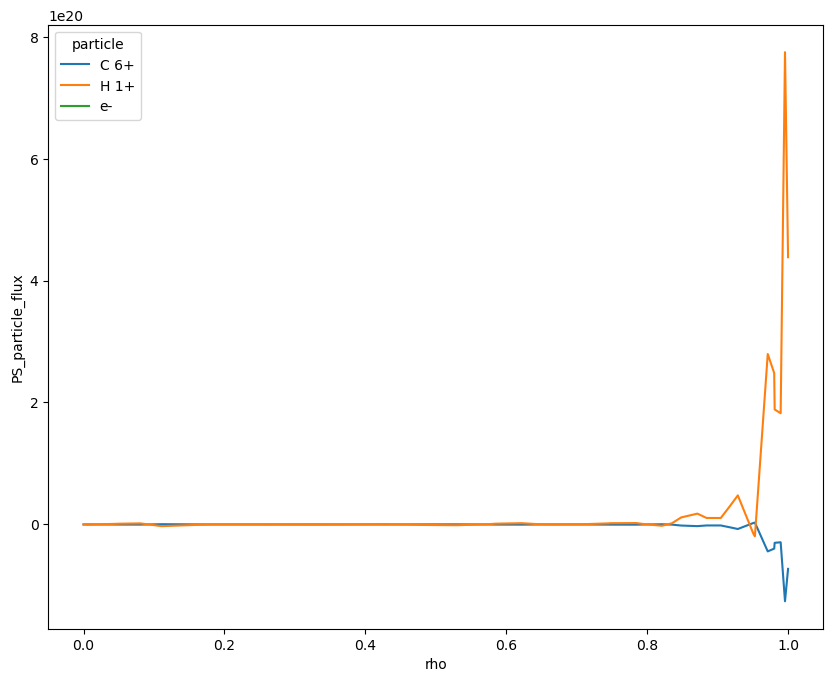

In [31]:
results.PS_particle_flux.plot.line(x="rho")

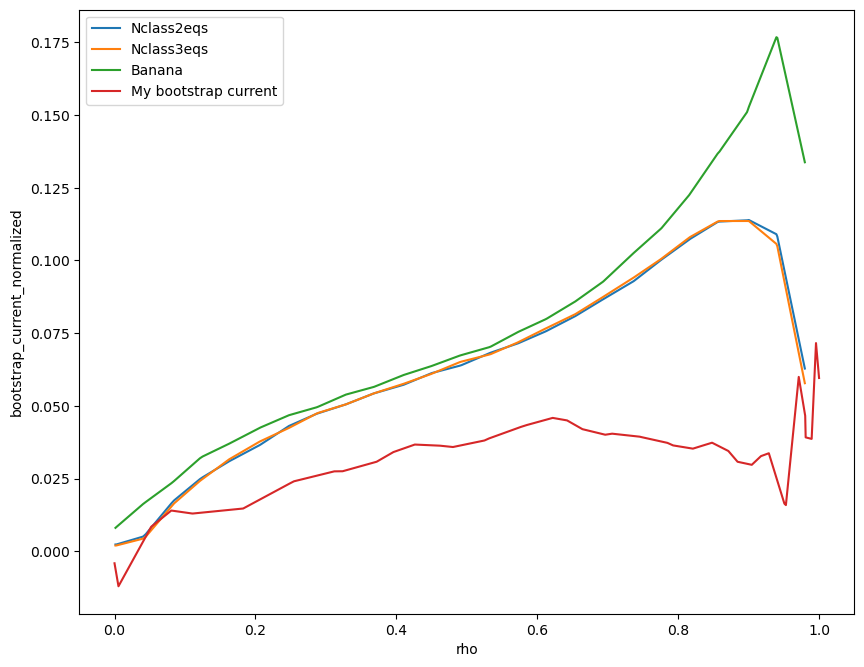

In [32]:
import pandas as pd

df = pd.read_csv("/home/dominik/Inbox/NSTXplot1.csv")

df.plot.line(x="x")
results.bootstrap_current_normalized.plot.line(x="rho", label="My bootstrap current")
plt.legend()

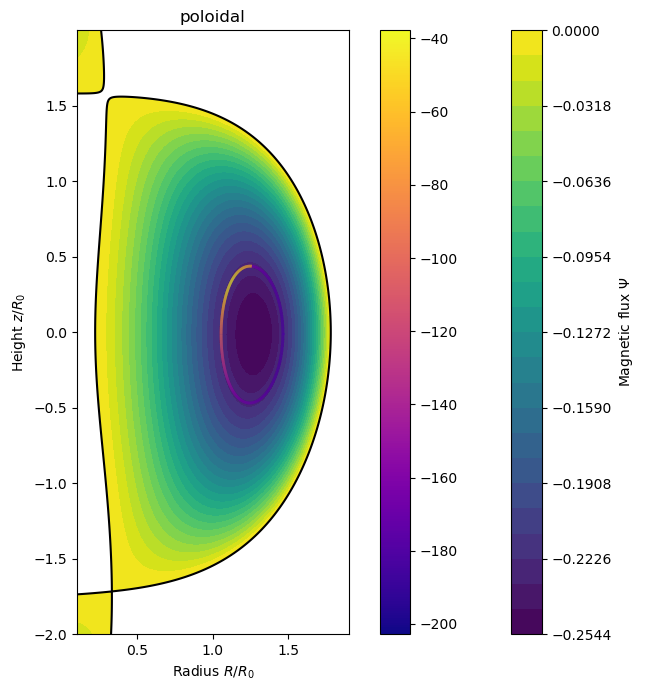

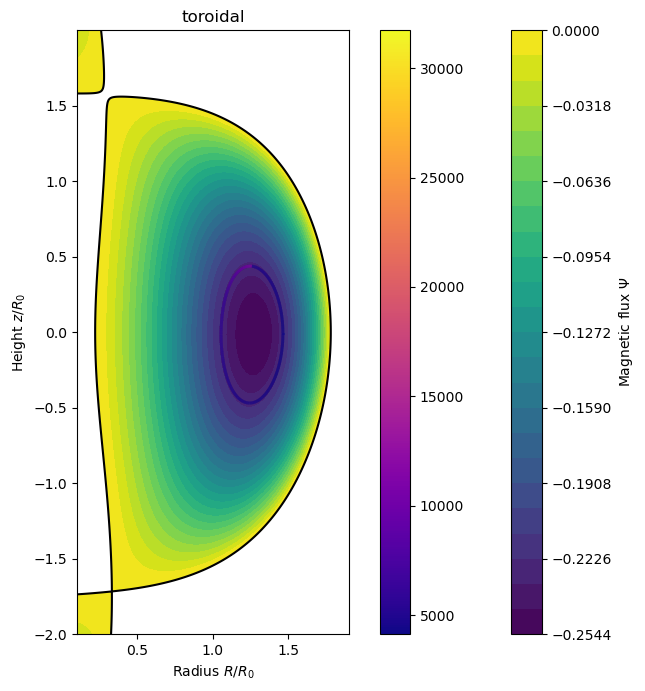

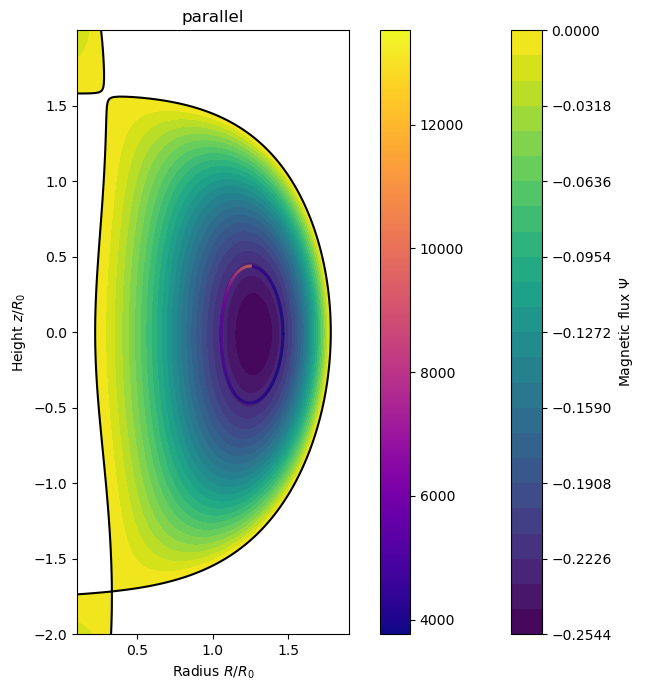

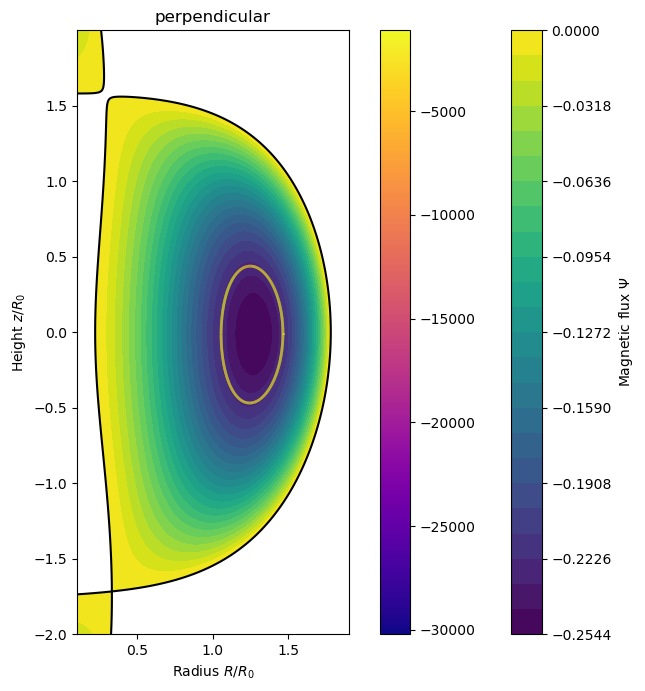

In [36]:
directions = ["poloidal", "toroidal", "parallel", "perpendicular"]
for index, label in enumerate(directions):
    ax = eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
    surfaces[5][1].plot(
        ax, quantity=fcs[-5].local_flow_velocities["H 1+"][index].value, legend=False
    )
    ax.set_title(label)

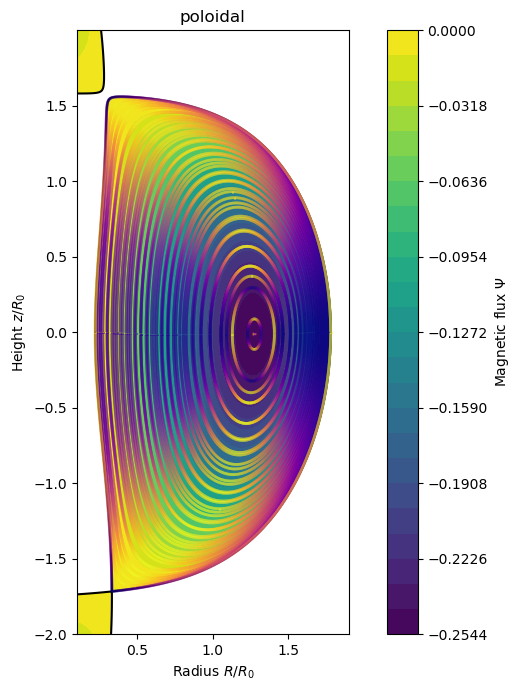

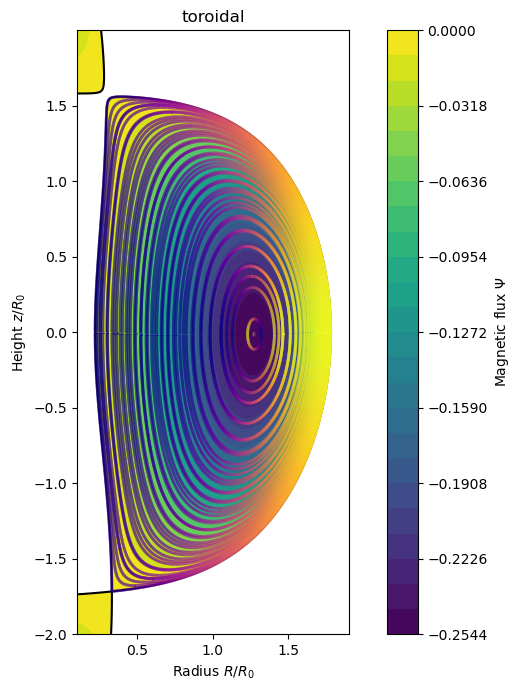

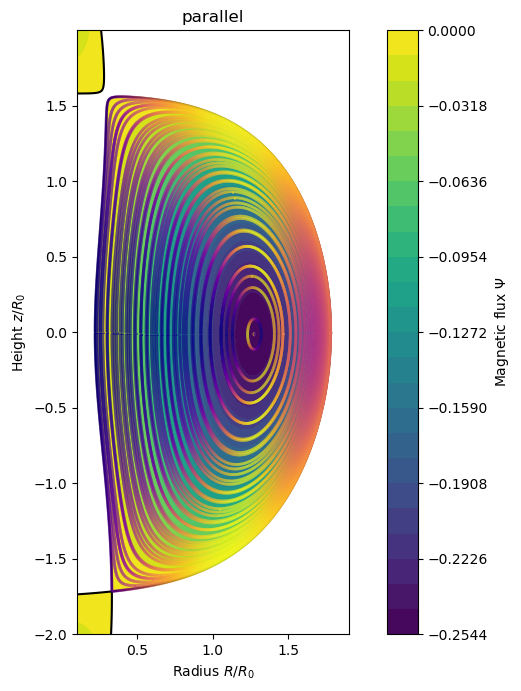

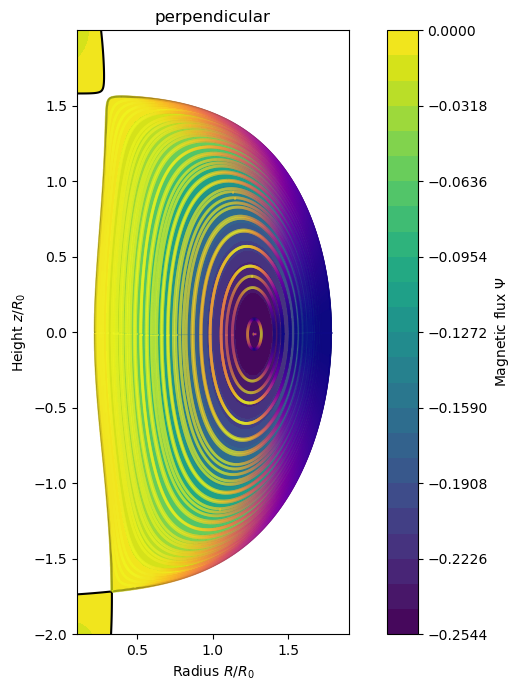

In [37]:
for index, label in enumerate(directions):
    ax = eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
    for (psi, surface), fc in zip(surfaces, fcs):
        surface.plot(
            ax,
            quantity=fc.local_flow_velocities["H 1+"][index].value,
            legend=False,
            colorbar=False,
        )
    ax.set_title(label)